## Joint inverse design

In [12]:
import sys; sys.path.append("../..") # use local neural_maxwell package

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from angler import Simulation, Optimization
from angler.structures import three_port, two_port

from pdb import set_trace as breakpoint
from time import time

import autograd.numpy as npa
from angler.objective import Objective, obj_arg

import numpy as np
import matplotlib.pyplot as plt

from neural_maxwell.datasets.generators1d import * 
from neural_maxwell.datasets.generators import Cavity2D, get_A_ops_2d
from neural_maxwell.constants import *
from neural_maxwell.utils import pbar, tensor_diff, tensor_roll

## Angler optimization

In [8]:
# define the similation constants
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 1e-1                   # grid size (L0)
NPML = [20, 20]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 1e-9           # amplitude of modal source (make around 1 for nonlinear effects)

# define material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity

# geometric parameters for a 1 -> 2 port device
L = 6         # length of box (L0)
H = 4         # height of box (L0)
w = .3        # width of waveguides (L0)
d = H/1.5     # distance between waveguides (L0)
l = 5         # length of waveguide from PML to box (L0)
spc = 3       # space between box and PML (L0)

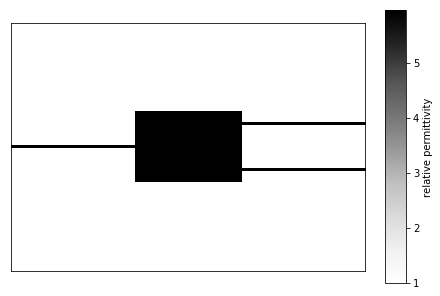

In [9]:
# define permittivity of three port system
eps_r, design_region = three_port(L, H, w, d, l, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

# make a new simulation object
simulation = Simulation(omega, eps_r, dl, NPML, pol)

# plot the permittivity distribution
simulation.plt_eps(outline=False)
plt.show()

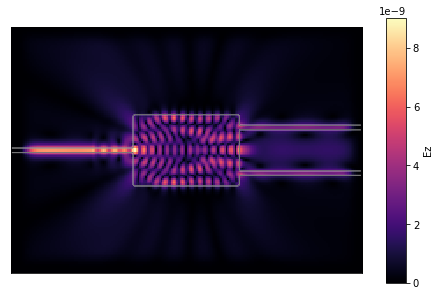

In [11]:
# set the input waveguide modal source
simulation.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[NPML[0]+int(l/2/dl), ny], width=int(H/2/dl), scale=source_amp)
simulation.setup_modes()

# make a new simulation to get the modal profile of the top output port
top = Simulation(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], width=int(H/2/dl))
top.setup_modes()
J_top = np.abs(top.src)

# make a new simulation to get the modal profile of the bottom output port
bot = Simulation(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], width=int(H/2/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

# set source and solve for electromagnetic fields
(Hx, Hy, Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

In [13]:
arg1 = obj_arg('ez', component='Ez', nl=False)

def J(ez):
    linear_top =     1*npa.sum(npa.square(npa.abs(ez*J_top)))
    linear_bot =     1*npa.sum(npa.square(npa.abs(ez*J_bot)))
    objfn = linear_top * linear_bot * 4
    return objfn

objective = Objective(J, arg_list=[arg1])

In [14]:
# make optimization object
R = 4          # filter radius of curvature (pixels)  (takes a while to set up as R > 5-10)
beta = 300     # projection strength
eta= 0.50      # projection halfway

optimization = Optimization(objective=objective, simulation=simulation, design_region=design_region, eps_m=eps_m, R=R, beta=beta, eta=eta)

 98% (148 of 151) |##################### | Elapsed Time: 0:00:14 ETA:   0:00:00

In [3]:
device = torch.device('cuda:0')

In [ ]:
class JointEvolver(nn.Module):
    
    def __init__(self, epsilons_init, E_init, src_pos=None, npml=16):
        super().__init__()
        
        if src_pos is None:
            src_y = epsilons_init.shape[0] // 2
            src_x = epsilons_init.shape[1] // 4
            self.src_pos = (src_y, src_x)
        else:
            self.src_pos = src_pos
        
        self.epsilons = nn.Parameter(torch.tensor(epsilons_init.flatten()), requires_grad=True)
        self.E_re = nn.Parameter(torch.tensor(np.real(E_init).flatten()), requires_grad=True)
        self.E_im = nn.Parameter(torch.tensor(np.imag(E_init).flatten()), requires_grad=True)
        
        self.physics_weight = 1e0
        self.objective_weight = 1e-1#1e-6
            
        # store angler operators
        curl_op, _ = get_A_ops_2d(np.ones(epsilons_init.shape), npml)
        self.curl_curl_re = torch.tensor(np.asarray(np.real(curl_op)), device=device).float()  
        self.curl_curl_im = torch.tensor(np.asarray(np.imag(curl_op)), device=device).float()  
    
    def get_physics_residual(self):
        # Compute Maxwell operator on fields
        curl_curl_E_re = (SCALE / L0**2) * (torch.matmul(self.curl_curl_re, self.E_re) 
                                            - torch.matmul(self.curl_curl_im, self.E_im))
        curl_curl_E_im = (SCALE / L0**2) * (torch.matmul(self.curl_curl_im, self.E_re) 
                                            + torch.matmul(self.curl_curl_re, self.E_im))

        epsilon_E_re = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E_re
        epsilon_E_im = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E_im

        # Compute free-current vector
        J_re = torch.zeros(batch_size, self.total_size, 1, device=device)
        J_im = torch.zeros(batch_size, self.total_size, 1, device=device)
        J_re[:, self.src_x, 0] = -1.526814027933079 # source is in phase with real part

        out_re = curl_curl_E_re - epsilon_E_re - J_re
        out_im = curl_curl_E_im - epsilon_E_im - J_im
        
        CONCAT = True
        if CONCAT: 
            # output is concatenated real and imaginary part
            out = torch.cat((out_re, out_im), dim=-1)
        else:
            # output is sum of real and imaginary part
            out = out_re + out_im 
    
    def get_objective_residual(self):
        node_location = 50
        return (self.fields[node_location + self.cavity_buffer] - 0).view(1)
    
    def forward(self, foo): 
        physics_loss = self.physics_weight * self.get_physics_residual()
        objective_loss = self.objective_weight * self.get_objective_residual()
        out = torch.cat([physics_loss, objective_loss])
        return out

# OUTDATED

In [148]:
class EpsilonTransformer(nn.Module):
    
    def __init__(self, epsilons_init, E_init, src_x = None, cavity_buffer=4):
        super().__init__()
        
        self.size = E_init.shape[0]
        if src_x is None:
            self.src_x = self.size // 4
        else:
            self.src_x = src_x
        self.cavity_buffer = cavity_buffer
        self.total_size = self.size + 2 * self.cavity_buffer
        
        self.epsilons = nn.Parameter(torch.tensor(epsilons_init), requires_grad=True)
        self.fields = nn.Parameter(torch.tensor(E_init), requires_grad=True)
        
        self.physics_weight = 1e0
        self.objective_weight = 1e-1#1e-6
            
        # store angler operators
        curl_op, eps_op = Cavity1D(device_length=self.size, cavity_buffer=self.cavity_buffer).get_operators()
        self.curl_curl_op = torch.tensor(np.asarray(np.real(curl_op)), device=device)
    
    def get_physics_residual(self):
        # Add zero field amplitudes at edge points for resonator BC's
        E = F.pad(self.fields, [self.cavity_buffer]*2)
#         E = E.view(batch_size, -1, 1)

        # Add first layer of cavity BC's
        eps = F.pad(self.epsilons, [self.cavity_buffer]*2, "constant", -1e20)
#         eps = eps.view(batch_size, -1, 1)

        # Compute Maxwell operator on fields
        curl_curl_E = (SCALE / L0**2) * torch.matmul(self.curl_curl_op, E)#.view(batch_size, -1, 1)
        epsilon_E = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E

#         epsilon_E = torch.bmm(self.epsilon_op, eps*E)

        # Compute free-current vector
#         J = torch.zeros(batch_size, self.total_size, self.total_size, device=device)
        J = torch.zeros_like(E, device=device)
        J[self.src_x + self.cavity_buffer] = -1.526814027933079 
#         J = J.view(batch_size, -1, 1)

        out = curl_curl_E - epsilon_E - J
#         out = out.view(batch_size, self.total_size, self.total_size)
        out = out[self.cavity_buffer:-self.cavity_buffer]
        
        return out
    
    def get_objective_residual(self):
        node_location = 50
        return (self.fields[node_location + self.cavity_buffer] - 0).view(1)
    
    def forward(self, foo): 
        physics_loss = self.physics_weight * self.get_physics_residual()
        objective_loss = self.objective_weight * self.get_objective_residual()
        out = torch.cat([physics_loss, objective_loss])
        return out

In [161]:
def epsilon_transform(epsilons, src_x=16, target_loss=1e-6, max_epochs=1e4):

    cavity_buffer = 4
    _, _, _, _, Ez = Cavity1D(device_length=len(epsilons), cavity_buffer=cavity_buffer).solve(epsilons, omega=OMEGA_1550, src_x=src_x)

    E_init = np.real(Ez[cavity_buffer:-cavity_buffer])
    model = EpsilonTransformer(epsilons, E_init, cavity_buffer=cavity_buffer).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    epochs = 0
    loss=1e10
    model.train()
    p = pbar(total=max_epochs)
    while loss > target_loss and epochs <= max_epochs:
        epochs += 1
        outputs = model(None)
        loss = criterion(outputs, torch.zeros_like(outputs))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        p.update()
        p.set_description("ℒ = {:.1e}".format(loss.item()), refresh=False)

    p.close()

    model.eval()        
    return model, model.fields.cpu().detach().numpy(), model.epsilons.cpu().detach().numpy()

In [162]:
epsilons = perm_random_number_alternating_layers()
model, fields, eps = epsilon_transform(epsilons)

In [163]:
epsilons - eps

array([ 2.15088235e-02,  4.37718726e-02,  4.25945922e-02,  3.47240102e-03,
       -2.32611501e-02,  5.61986451e-03,  4.85762966e-02,  6.76920467e-02,
        9.66438356e-02,  8.33122191e-02,  6.45059685e-02,  5.75134720e-02,
        4.72054161e-02,  2.80592172e-02, -2.51681420e-02,  5.78153883e-02,
        4.41194286e-02,  4.88264693e-03,  4.34910236e-02,  5.67355368e-02,
        5.48832856e-02, -5.26036313e-02,  5.25891570e-02,  7.93174589e-02,
        4.98374991e-02, -1.58163559e-02,  7.43210213e-02,  7.80350139e-02,
       -6.82917040e-03, -1.11200519e-01, -1.91982773e-01, -2.92173051e-01,
        3.76063014e-02,  8.05025731e-01,  3.30724034e+00,  5.38257083e+00,
        5.10525089e+00, -6.93259239e+00, -2.59754648e+00,  6.51733558e+00,
        6.14801428e+00, -7.11864664e+00, -5.37542772e+00,  5.49361754e+00,
        5.09645856e+00, -8.01913084e+00, -4.75986535e+00,  1.61608058e+00,
        5.41720911e+00, -9.72419068e+00, -4.17448391e+00,  6.66916034e-02,
        5.03087972e+00,  

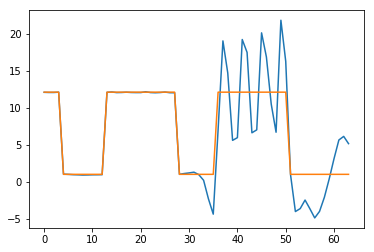

In [164]:
plt.plot(eps)
plt.plot(epsilons)
plt.show()

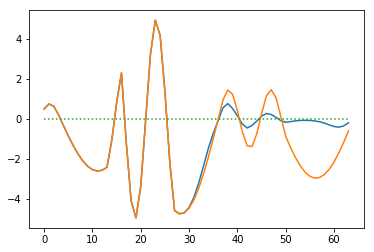

In [165]:
_, _, _, _, Ez = Cavity1D(device_length=len(epsilons), cavity_buffer=cavity_buffer).solve(epsilons, omega=OMEGA_1550, src_x=src_x)
E_init = np.real(Ez[cavity_buffer:-cavity_buffer])
# plt.plot(fields-E_init)
plt.plot(fields)
plt.plot(E_init)
plt.plot(np.zeros(fields.shape), linestyle=':')
plt.show()

In [146]:
fields[54]

0.587747781818845

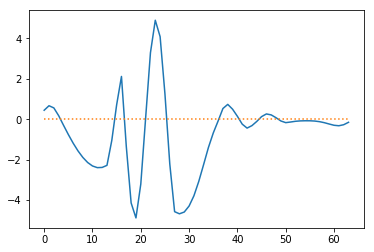

In [166]:
_, _, _, _, Ez = Cavity1D(device_length=len(epsilons), cavity_buffer=cavity_buffer).solve(eps, omega=OMEGA_1550, src_x=src_x)
# plt.plot(fields-E_init)
plt.plot(np.real(Ez[cavity_buffer:-cavity_buffer]))
plt.plot(np.zeros(fields.shape), linestyle=':')
plt.show()